# Recommendation system for movies

In [1]:
#%matplotlib inline
from collections import defaultdict
import json
import gzip
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

1. Filtro basado en contenido: Cuando no hay perfiles de gente similar a ti para ofrecerte algo (lanzamiento de nuevos productos)
2. **Filtro colaborativo**: Usar informacion de otras personas con perfiles similares al tuyo y ofrecerte cosas que esa gente ha comprado y tu no (KNN y NMF=Negative Matrix Factorization)
3. Data Mining (Basket Market Analysis)

## Objetivo

En este caso, creará un **sistema de recomendación** para películas usando **[filtrado colaborativo](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF)**. El filtrado colaborativo se basa en las reseñas de los usuarios sobre una lista de elementos y utiliza el comportamiento anterior de los usuarios para recomendar elementos que aún no han probado pero que podrían interesarles.

Hay dos enfoques principales para la FC: **comparación basada en vecindarios** y **modelado de factores latentes**. El primero se ocupa de calcular las relaciones entre elementos o entre usuarios. En este último enfoque, se tiene un modelo de factores ocultos a través del cual los usuarios y los elementos se transforman en el mismo espacio. Por ejemplo, si califica películas, podemos transformar los elementos en diferentes géneros y los usuarios en sus preferencias por un género en particular. Al final del caso, aprenderá cómo realizar CF utilizando ambos enfoques.


## Introduccion

**Contexto empresarial.** La mayoría de las empresas comerciales en línea utilizan sistemas de recomendación automatizados para aumentar la participación de los clientes. Un sistema de recomendación eficiente y preciso conecta a los clientes con empresas y servicios que nunca han utilizado antes, pero con los que es muy probable que interactúen. Usted es el ingeniero jefe de una empresa emergente que tiene como objetivo proporcionar experiencias de entretenimiento personalizadas. Su empresa quiere que construya un sistema de recomendación que sugiera películas y programas de televisión que se adapten a los gustos de los usuarios.

**Problema empresarial.** Su tarea principal es utilizar las reseñas que sus usuarios han escrito sobre películas y programas de televisión en Amazon **para construir un sistema de recomendación automático que prediga la probabilidad de que un usuario disfrute de una película, en función de la cual también generará una lista de películas/programas de televisión que el usuario nunca ha visto antes, pero que probablemente disfrutaría.** 

**Contexto analítico.** El esquema de este caso es el siguiente: (1) crearemos una base de datos de similitudes entre elementos y la utilizaremos para implementar un recomendador de similitudes basado en el vecindario que pueda responder preguntas simples como "dame más películas como esta". Esta parte del caso supone que las similitudes calculadas constituyen buenas "recomendaciones globales"; (2) ir un paso más allá e intentar predecir la calificación que un usuario le dará a una película que no ha visto antes. Esto requiere que encontremos las películas que *este* usuario calificaría como similares (no solo aquellas que son similares en general); y finalmente (3) implementar un recomendador de CF basado en factores latentes utilizando una factorización matricial no negativa.

## Comparación basada en KNN versus factores latentes 

Como se mencionó anteriormente, existen dos enfoques principales para la FC: **KNN** y **modelado de factores latentes**.

Los enfoques originales de la CF basada en KNN usando modelos de usuario-usuario. Esto significa que estimaríamos la calificación que un usuario particular le daría a un artículo en particular en función de las calificaciones reales que otros usuarios similares le dieron a ese artículo. Sin embargo, dado que la mayoría de los usuarios tienden a calificar muy pocos elementos, esta no suele ser la mejor manera de construir sistemas de recomendación centrados en calificaciones. Por lo tanto, hoy en día la mayoría de los sistemas basados ​​en KNN (por ejemplo, Amazon) se basan en enfoques artículo-artículo. En este enfoque, una calificación se estima utilizando la calificación que el usuario particular dio a otros elementos similares; es decir, efectivamente tenemos una especie de algoritmo de $k$ vecinos más cercanos.

Los modelos de factores latentes generalmente conducen a recomendaciones más precisas. Una de las razones de esto es la escasez de la matriz elemento-usuario. La mayoría de los usuarios tienden a calificar apenas uno o dos artículos. Los modelos de factores latentes son más expresivos y se ajustan a menos parámetros. Sin embargo, prevalecen los modelos de KNN, ya que tienen un aspecto intuitivo que atrae a los usuarios (si te gustó esto te gustará aquello) y online (muy rápidamente se puede incorporar una nueva preferencia).

## Explorando la data

Los datos que estamos utilizando son una versión reducida de las reseñas de películas y programas de televisión de Amazon (disponibles [aquí](http://jmcauley.ucsd.edu/data/amazon/)). Cada entrada en este DataFrame es una revisión específica en la que solo registramos la identificación del usuario, la identificación de la película y la clasificación de la película. También tenemos una lista de metadatos que se pueden utilizar para asignar ID de películas a títulos de películas reales:

CSV: https://drive.google.com/file/d/1nRAbCmwefDQne0QKTdpcNN4fnAEIrWU2/view?usp=sharing

TAR: https://drive.google.com/file/d/1A9wrXiBIJeyURUoS20Tfsmfdb3perQ_w/view?usp=sharing

In [2]:
movie_title_dict = {}
with gzip.open('meta_Movies_and_TV.json.gz', 'rt', encoding='ascii') as zipfile:
    for line in zipfile:
        tmp = json.loads(line)
        try:
            movie_title_dict[tmp['asin']] = tmp['title']
        except KeyError:
            continue

In [4]:
len(movie_title_dict.keys())

181976

In [8]:
fulldf=pd.read_csv("amazon_movie_reviews.csv")
fulldf.head(2)

,item,user,rating
0,0001527665,A3478QRKQDOPQ2,5.0
1,0001527665,A2VHSG6TZHU1OB,5.0


In [9]:
fulldf.shape

(4382784, 3)

Campos

* **rating**: star rating (integer 1 - 5)
* **item**: unique ID for a movie
* **user**: unique ID for a user


En este conjunto de datos, ¿cuántos usuarios tienen más de una reseña para una sola película? ¿Para estos usuarios siempre dan la misma puntuación a la misma película? Si un usuario reseña una película más de una vez y las calificaciones son diferentes, ¿qué le gustaría hacer para agregar todas estas reseñas? Escribe código para implementar lo que propones.

In [11]:
check = fulldf.groupby(['user','item']).size().reset_index(name='count')
print("No. of users que dan una revision mas de una vez:", len(check[check['count']>1].user.unique()))

No. of users que dan una revision mas de una vez: 206800


In [12]:
fulldf.groupby(['user','item']).agg({'rating':['size','std']})

rating    
                                  size std
user                 item                 
A0001392IVCRENBEIEYS 6302409365      1 NaN
A0002090WKEMAO8KOWKM 779913027X      1 NaN
                     B0036TGSWG      1 NaN
A00049826E18XJLZ3YC0 B001FB55JO      1 NaN
A0007430W3WXY3QNYB2S B003HC9JIW      1 NaN
...                                ...  ..
AZZZKII78NDE9        B00020HAY2      1 NaN
AZZZMSZI9LKE6        6303421156      1 NaN
                     B00008DDJD      1 NaN
                     B000OYCMMQ      1 NaN
AZZZQEK5E6KN         B001HB3PMQ      1 NaN

[4132428 rows x 2 columns]

In [13]:
check_diff = fulldf.groupby(['user','item']).agg({'rating':['size','std']}).reset_index()
check_diff.columns = ['_'.join(col).strip("_") for col in check_diff.columns.values]
check_diff

,user,item,rating_size,rating_std
0,A0001392IVCRENBEIEYS,6302409365,1,NaN
1,A0002090WKEMAO8KOWKM,779913027X,1,NaN
2,A0002090WKEMAO8KOWKM,B0036TGSWG,1,NaN
3,A00049826E18XJLZ3YC0,B001FB55JO,1,NaN
4,A0007430W3WXY3QNYB2S,B003HC9JIW,1,NaN
...,...,...,...,...
4132423,AZZZKII78NDE9,B00020HAY2,1,NaN
4132424,AZZZMSZI9LKE6,6303421156,1,NaN
4132425,AZZZMSZI9LKE6,B00008DDJD,1,NaN
4132426,AZZZMSZI9LKE6,B000OYCMMQ,1,NaN


In [14]:
print("No. of user+movie combi. con mas de una review :", check_diff[(check_diff.rating_size>1) & (check_diff.rating_std>0)].shape[0] )

No. of user+movie combi. con mas de una review : 2748


Los resultados anteriores indican que algunos usuarios revisan una sola película varias veces con diferentes calificaciones. Elegimos tomar el **promedio** de estas calificaciones para agregarlas:

In [15]:
usedf = fulldf.groupby(['user','item']).agg({'rating':['mean']}).reset_index()
usedf.columns = [col[0] for col in usedf.columns.values]
usedf

,user,item,rating
0,A0001392IVCRENBEIEYS,6302409365,5.0
1,A0002090WKEMAO8KOWKM,779913027X,5.0
2,A0002090WKEMAO8KOWKM,B0036TGSWG,5.0
3,A00049826E18XJLZ3YC0,B001FB55JO,5.0
4,A0007430W3WXY3QNYB2S,B003HC9JIW,5.0
...,...,...,...
4132423,AZZZKII78NDE9,B00020HAY2,5.0
4132424,AZZZMSZI9LKE6,6303421156,4.0
4132425,AZZZMSZI9LKE6,B00008DDJD,5.0
4132426,AZZZMSZI9LKE6,B000OYCMMQ,5.0


From now on, we will work with `usedf` for all the analyses.

Comencemos explorando `usedf`. Trazaremos dos histogramas, uno del número de reseñas por usuario y otro del número de reseñas por artículo:

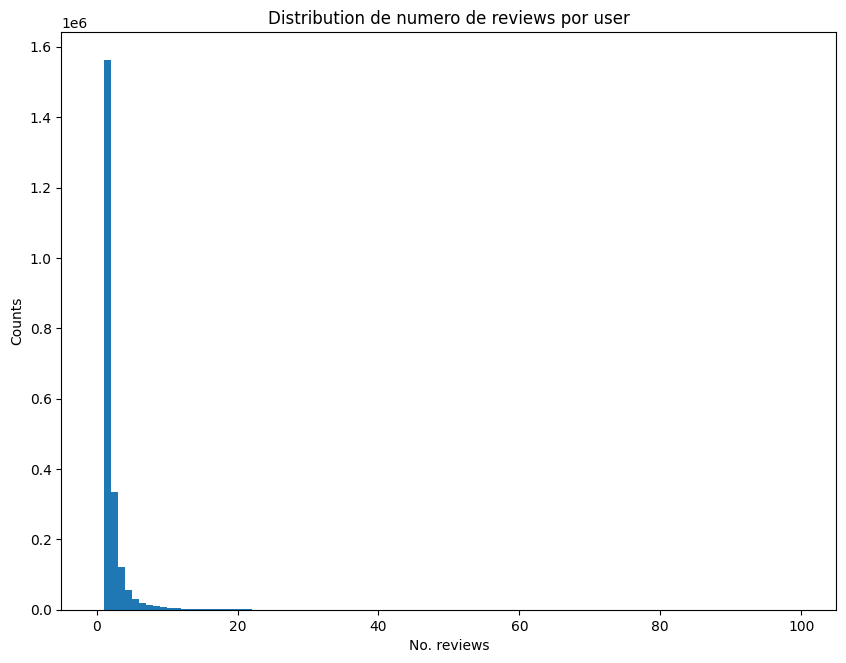

In [16]:
def myhist( data, title, xlab, n_bins = 100, density = False, range = [0,100] ):
    fig = plt.figure( figsize=(10,7.5) )
    ax = plt.gca()
    n, bins, patches = ax.hist( data, bins = n_bins, density = density, range = range )
    plt.xlabel( xlab )
    if density:
        plt.ylabel( "Density" )
    else:
        plt.ylabel( "Counts" )
    plt.title( title )

myhist( usedf.groupby( "user" ).size(), "Distribution de numero de reviews por user", "No. reviews" )

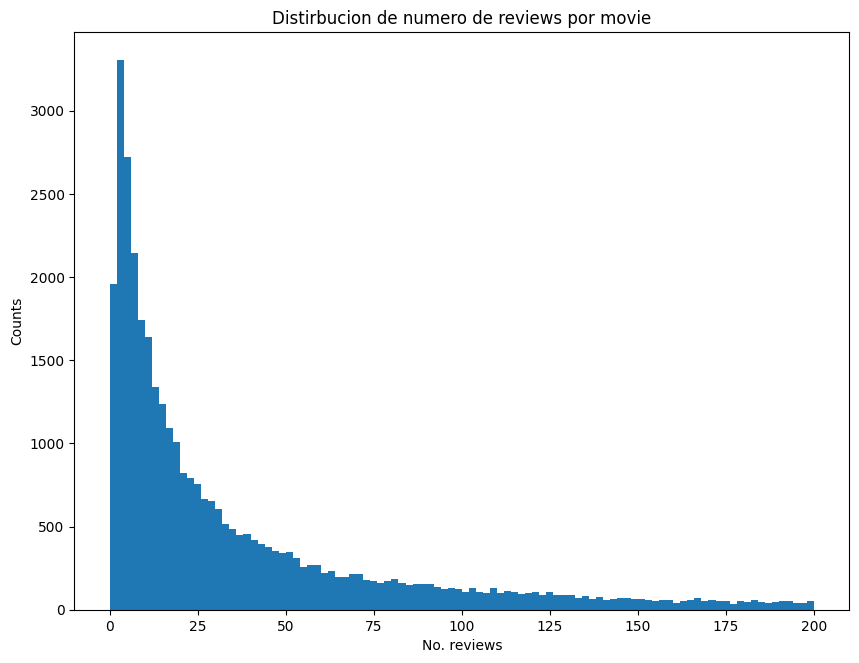

In [11]:
myhist( usedf.groupby( "item" ).size(), "Distirbucion de numero de reviews por movie", "No. reviews", range = [0,200] )

In [17]:
print("The number of users is", usedf.user.unique().size)
print("The number of movies is", usedf.item.unique().size)

The number of users is 2189850
The number of movies is 38995


Podemos encontrar que la gran mayoría de los usuarios califican menos de 25 películas, lo que significa que la mayoría de los usuarios no expresan sus opiniones por más de $1 - \frac{38970}{38995}\approx 0.01\%$ de películas. La distribución del número de reseñas por película generalmente se agrupa por debajo de 200. Esto significa que la mayoría de las películas no reciben comentarios de más de $1 - \frac{2189650}{2189850}\approx 0,01\%$ usuarios. Estas cifras pueden sugerir que el conjunto de datos es bastante escaso; es decir, contiene muchos "datos faltantes". Esto corrobora nuestra afirmación anterior sobre los modelos de comparación basados ​​en knn; es decir, que cada usuario revisa relativamente pocos artículos y, de hecho, cada artículo es revisado por relativamente pocos usuarios (aunque en promedio es considerablemente más alto que el primero).


También podemos calcular la calificación promedio de las reseñas en el conjunto de datos y trazar un histograma de todas las calificaciones en el conjunto de datos:

Avg rating de todas reviews en dataset 4.30


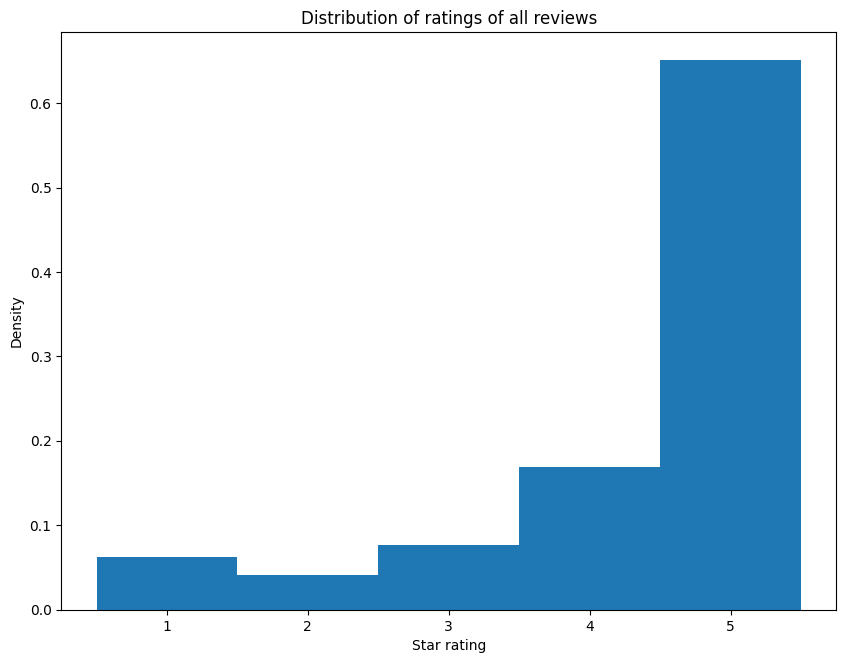

In [18]:
print("Avg rating de todas reviews en dataset %.2f" % usedf.rating.mean())
myhist( usedf.rating, "Distribution of ratings of all reviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

Podemos ver que el histograma no es uniforme; hay una fracción no significativa (~8%) de 1 calificación y un gran grupo de 5 calificaciones. Esto es muy común en las reseñas de películas.

### Creando dataset mas pequeño

Ahora creemos un conjunto de datos más pequeño en DataFrame `smalldf` buscando aquellas películas con más de 2200 reseñas (películas populares/clásicas) y aquellos usuarios con más de 65 reseñas. Tenga en cuenta que, si bien este recorte garantiza que tengamos usuarios prolíficos, el recorte de películas restaura la escasez al reducir la cantidad de reseñas por usuario. También incluimos en `smalldf` una columna `user_mean` para indicar la calificación promedio que otorga un usuario y una columna `movie_mean` para indicar la calificación promedio que recibe esta película. Después del filtrado inicial, eliminamos aún más a los usuarios que ahora tienen menos de 6 reseñas y películas con menos de 3 reseñas:

In [26]:
#get subset
df1 = usedf.groupby("user").size().reset_index(name="count_user")
df2 = usedf.groupby("item").size().reset_index(name="count_movie")

usedf1 = usedf.merge(df1, 'left', on = 'user').merge(df2, 'left', on = 'item')

smalldf = usedf1[(usedf1.count_movie > 2200) & (usedf1.count_user > 65)]
mean_user = smalldf.groupby("user").rating.mean().reset_index(name="user_mean")
mean_movie = smalldf.groupby("item").rating.mean().reset_index(name="movie_mean")
smalldf = smalldf.merge(mean_user, 'left', on = 'user').merge(mean_movie, 'left', on = 'item')
smalldf = smalldf.drop(["count_user","count_movie"], axis = 1)

# filter out reviewers with too few reviews
tmp = smalldf.groupby('user').size()
smalldf = smalldf[smalldf.user.isin(tmp.index[tmp>5])]

# filter out movies with too few reviews
tmp_mov = smalldf.groupby('item').size()
smalldf = smalldf[smalldf.item.isin(tmp_mov.index[tmp_mov>2])]
smalldf

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.476190,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.476190,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.476190,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.476190,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.476190,4.546512
...,...,...,...,...,...
11636,AZSN1TO0JI87B,B00005JNJV,5.0,4.142857,4.480545
11637,AZSN1TO0JI87B,B00005JPY0,5.0,4.142857,4.340796
11638,AZSN1TO0JI87B,B00006JE59,3.0,4.142857,4.500000
11639,AZSN1TO0JI87B,B0002WYTWG,5.0,4.142857,4.471795


Podemos repetir el análisis exploratorio de la sección anterior que realizamos en `used`, en su lugar en `smallpdf`:

The number of users is 778.
The number of movies is 173.


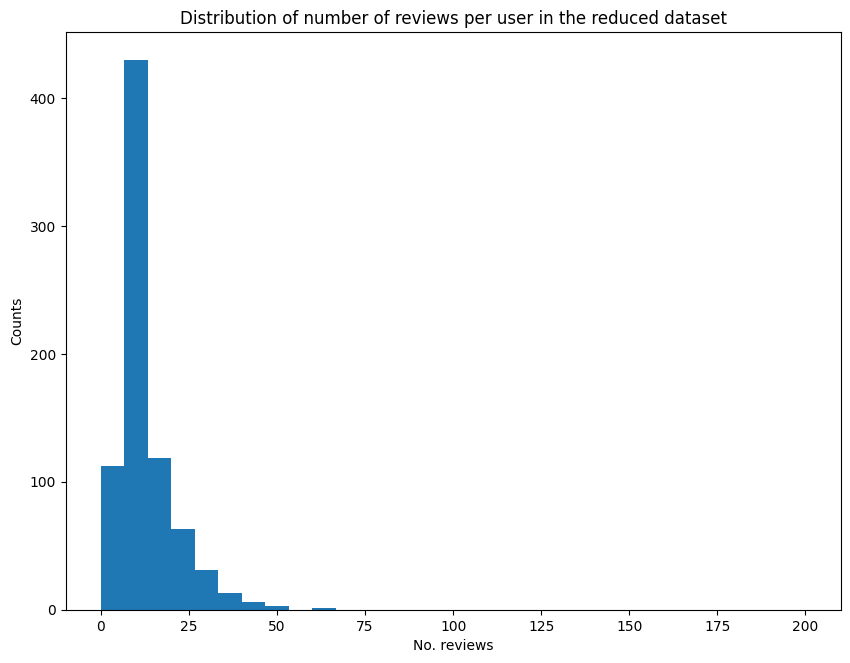

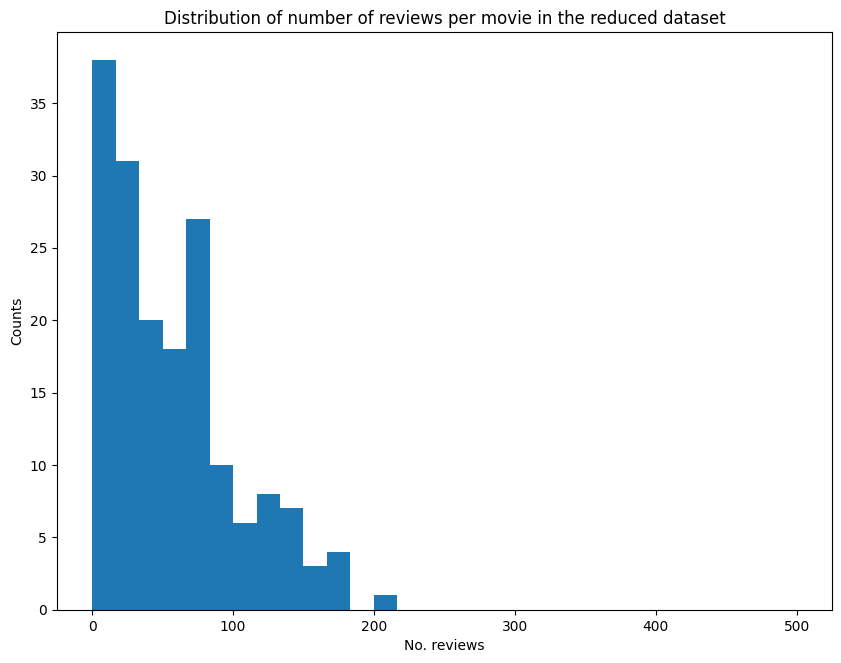

In [27]:
#repeat ex2
myhist( smalldf.groupby("user").size(), 
       "Distribution of number of reviews per user in the reduced dataset", "No. reviews", n_bins = 30, range = [0,200] )
myhist( smalldf.groupby("item").size(), 
       "Distribution of number of reviews per movie in the reduced dataset", "No. reviews", n_bins = 30, range = [0,500] )

print( "The number of users is %d." % smalldf.user.unique().size )
print( "The number of movies is %d." % smalldf.item.unique().size )

**sparsity**
- sparsity < 0.5 (Menos de la mitad de celdas vacias en una matriz)

In [79]:
778*173

134594

Podemos encontrar que el número de reseñas por usuario se acumula principalmente por debajo de 50, lo que significa que la mayoría de los usuarios no expresan su opinión sobre aproximadamente $\frac{123}{173}\approx 71\%$ películas. En cuanto al número de reseñas por película, se acumula principalmente por debajo de 200, lo que significa que la mayoría de las películas no reciben ningún comentario de alrededor de $\frac{578}{778}\approx 74\%$ de usuarios. En comparación con el conjunto de datos completo, la escasez se reduce (99,99% a 71% y 74% respectivamente).


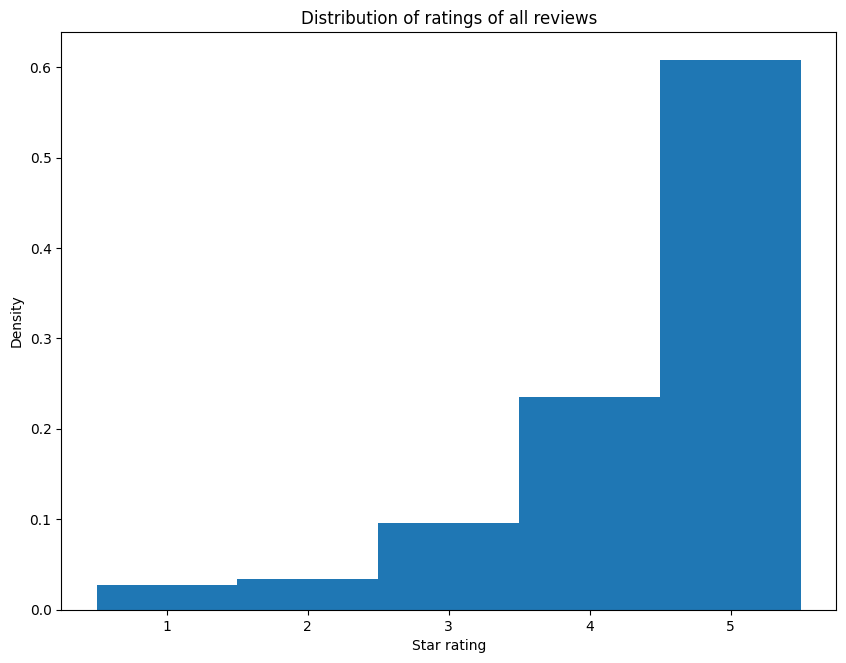

In [28]:
myhist( smalldf.rating, "Distribution of ratings of all reviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

La distribución pasó de una "forma de U" a una distribución unimodal con un máximo de 5 estrellas. Esto se debe a que las películas con más críticas tienden a ser mejores que las que reciben menos críticas.

## Primer modelo de recomendacion

Digamos que la calificación promedio de las películas en Amazon es 3,5. *The Fellowship of the Ring* es mejor que la mayoría de las películas, y su calificación promedio es probablemente 1,3 por encima del promedio global (entre todos los usuarios). Sin embargo, usted es bastante estricto a la hora de otorgar 5 estrellas a cualquier película y tiende a calificar todas las películas con 0,5 estrellas por debajo del promedio. Por lo tanto, una estimación de referencia para su calificación de *La Comunidad del Anillo* es 3,5+1,3-0,5=4,3.

Una estimación de referencia, como la ilustrada anteriormente, tiene en cuenta las tendencias sistemáticas de algunos usuarios que otorgan calificaciones más bajas en todos los ámbitos que otros (y viceversa). Podemos escribir la estimación de referencia para una calificación desconocida $\text{Rating}_{um}$ para el usuario $u$ y la película $m$ como:


$$
\text{Baseline Rating}_{u}(m) = \text{Global average} + \text{Movie deviation}_m + \text{User deviation}_u
$$

donde $\text{Global average}$ es la calificación promedio de todas las películas y todos los usuarios. Los valores desconocidos $\text{Desviación de la película}_m$ y $\text{Desviación del usuario}_u$ indican las desviaciones del usuario $u$ y del elemento $m$, respectivamente, del promedio global.

Lo más sencillo para empezar, para obtener una estimación de $\text{Desviación de la película}_m$ y $\text{Desviación del usuario}_u$, es lo siguiente:
$$
\text{Movie deviation}_m = \text{Average rating}_m - \text{Global average}\\
\text{User deviation}_u = \text{Average rating}_u - \text{Global average}
$$

Esto está directamente motivado por el ejemplo anterior: $\text{Desviación de la película}_m$ es la desviación de las calificaciones de la película $m$ con respecto a la calificación promedio global y $\text{Desviación del usuario}_u$ es la desviación de las calificaciones de la película del usuario $u$ a la calificación promedio global.

Que puedes criticar de esta idea?

El siguiente código toma el DataFrame y una identificación de usuario y devuelve una lista de estimaciones de referencia de calificaciones para todas las películas:

In [29]:
smalldf

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.476190,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.476190,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.476190,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.476190,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.476190,4.546512
...,...,...,...,...,...
11636,AZSN1TO0JI87B,B00005JNJV,5.0,4.142857,4.480545
11637,AZSN1TO0JI87B,B00005JPY0,5.0,4.142857,4.340796
11638,AZSN1TO0JI87B,B00006JE59,3.0,4.142857,4.500000
11639,AZSN1TO0JI87B,B0002WYTWG,5.0,4.142857,4.471795


In [30]:
def baseline_recommend( df, user ):
    user_mean = df[df.user == user].rating.mean()
    movie_mean = df.groupby('item').rating.mean()
    return user_mean + movie_mean - df.rating.mean()


Hagamos algunas recomendaciones. Enumere 10 películas con la calificación estimada más alta para el usuario `A101IGU6UDKW3X`, según el conjunto de datos "smalldf". Tenga en cuenta que puede utilizar el diccionario `movie_title_dict` para asignar ID de películas a títulos de películas.

In [37]:
user_all_ratings = baseline_recommend( smalldf, 'A101IGU6UDKW3X')

rating_10 = user_all_ratings.sort_values(ascending = False)[:10]
rating_10.index = [movie_title_dict[x] for x in rating_10.index]
print(rating_10.reset_index())

                                               index    rating
0     Lark Rise To Candleford - Series 3 Region Free  5.113216
1                                          Five Days  5.113216
2                     Curb Your Enthusiasm: Season 8  5.113216
3                                 Wrong Trousers VHS  5.113216
4                               NYPD Blue - Season 1  5.113216
5  24 - Season 5 2006 Kiefer Sutherland; Carlos B...  5.054393
6               Toy Story (Mandarin Chinese Edition)  5.049925
7                                Fiddler on the Roof  4.992004
8                                 The Wire: Season 3  4.979883
9                             My Neighbor Totoro VHS  4.973682


¿Cómo se puede mejorar la calificación inicial anterior?

## Un paso más allá: la recomendación global del vecino más cercano

La estimación de referencia que acabamos de implementar es bastante burda. Esto se debe a que las estimaciones de referencia solo utilizan información sobre *este* usuario en particular y *esta* película en particular.

Para cualquier usuario determinado, podemos hacer un mejor trabajo recomendando al encontrar películas que sean similares a las que ya ha visto y que tengan altas calificaciones. Esta es realmente la idea del **filtrado colaborativo**: tomar prestada información de otros usuarios y sus preferencias. Este enfoque requiere una medida de similitud para un par de películas. Los candidatos potenciales incluyen [similitud de coseno] (http://en.wikipedia.org/wiki/Cosine_similarity), [coeficiente de Pearson] (http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coficient) y otros basados ​​en distancia. medidas. Aquí usaremos el coeficiente de Pearson. Mide la tendencia de dos usuarios similares a calificar dos artículos similares de manera similar. Dado que la mayoría de las calificaciones son desconocidas, se calculan según el "grupo de usuarios comunes", que es el conjunto de evaluadores comunes de un par de películas.

Analicemos con un poco más de detalle cómo calculamos la similitud. Para dos películas $u$ y $v$, encontramos todos los usuarios que las calificaron y calculamos el coeficiente de Pearson entre esos dos conjuntos de calificaciones. Intuitivamente, si el coeficiente es cercano a 1, estas dos películas tienen méritos similares. Calculamos la similitud entre $u$ y todas las demás películas y seleccionamos las mejores películas $k$ con los coeficientes de Pearson más altos como candidatas para recomendación, siempre que al usuario realmente le guste la película $u$.




Alguna critica a esta idea?

El recomendador global tiene la ventaja de abordar el problema de los datos faltantes en el conjunto de datos original, pero puede ser demasiado rígido en el sentido de que no tiene en cuenta las preferencias personales de los usuarios. Además, si solo hay un pequeño número de usuarios comunes (por ejemplo, 2), entonces la correlación no es confiable ya que podría no reflejar una tendencia general.

Bueno implementemos el global recommender step-by-step.

Escriba una función para encontrar los usuarios comunes que calificaron tanto `mov1` como `mov2`. La entrada de esta función debe ser el conjunto de datos y las dos ID de película. Esta función debería devolver una lista de ID de usuario que revisaron ambas películas. Utilice esta función para trazar un histograma de la distribución del número de críticos comunes para todos los pares de películas basadas en "smalldf". ¿Cuál es el número promedio de revisores comunes?


In [38]:
def find_ncommon(df, mov1, mov2):
    u1 = df[df.item==mov1].user
    u2 = df[df.item==mov2].user
    ucom = np.intersect1d(u1, u2)
    return ucom

In [41]:
len(find_ncommon(smalldf, '0767853636', '0792158202'))

4

In [47]:
from itertools import combinations
#[x for x in combinations(smalldf.item.unique(),2)]

In [48]:
from itertools import combinations

ncom_dist = [len(find_ncommon(smalldf, pair[0], pair[1])) for pair in combinations(smalldf.item.unique(),2)]

Averge ncommon: 5.535421427611238


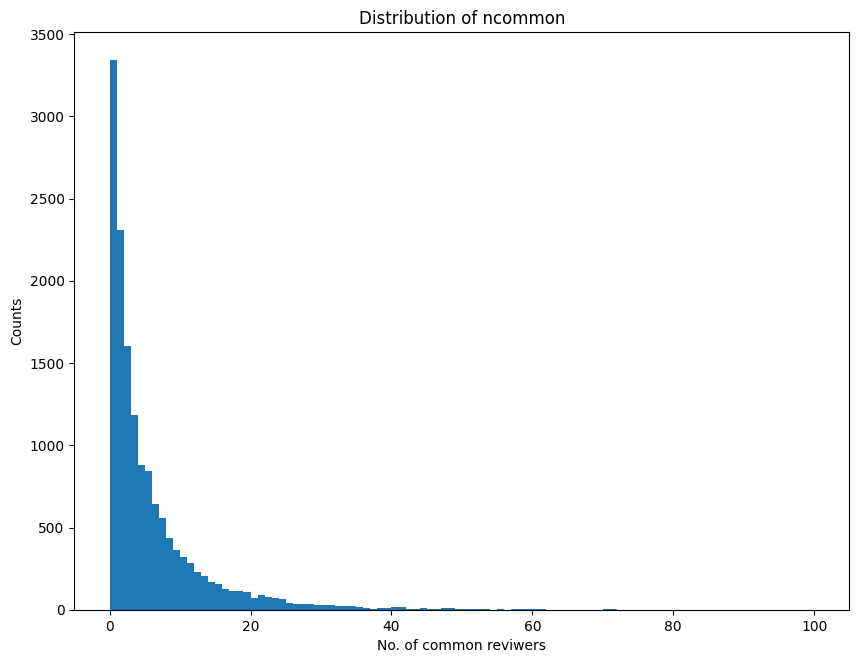

In [49]:
myhist( ncom_dist, title = "Distribution of ncommon", xlab = "No. of common reviwers" )
print("Averge ncommon:", np.mean(ncom_dist))

Como puede ver, aunque elegimos un subconjunto del DataFrame en el que cada película tenía al menos 1000 reseñas y cada usuario había reseñado al menos 100 películas, el número de críticos comunes de la mayoría de los pares de películas es bastante bajo. Ahora escribamos una función para calcular la similitud entre dos películas, según sus críticos comunes:

Utilice la función `personr` de `scipy.stats.stats` para calcular la similitud entre dos películas. Si dos películas no tienen ningún revisor común o solo tienen uno, el valor predeterminado es cero. Si uno o ambos vectores de calificación tienen una varianza cero, lo dejamos en "nan", la salida predeterminada de "pearsonr". Esta función debe tomar tres entradas, un DataFrame y dos ID de película. Esta función debería devolver el coeficiente de Pearson junto con el número de revisores comunes en una tupla. Con esta función, calcula la similitud entre las películas `0767853636` y `0790729628`.

In [50]:
from scipy.stats.stats import pearsonr
def pearson_sim(df, mov1, mov2):
    ucommon = find_ncommon(df, mov1, mov2)
    if len(ucommon)<2:
        rho=0.
    else:
        mov1_df = df[(df.item==mov1)&(df.user.isin(ucommon))]
        mov2_df = df[(df.item==mov2)&(df.user.isin(ucommon))]
        mov1_score = mov1_df.rating - mov1_df.user_mean  ## notice this step
        mov2_score = mov2_df.rating - mov2_df.user_mean  ## notice this step
        rho=pearsonr(mov1_score, mov2_score,)[0]
    return (rho, len(ucommon))

In [51]:
sim_res = pearson_sim( smalldf, '0767853636', '0790729628')
#sim_res = pearson_sim( smalldf, 'B00005JPY0', '0790729628')
print("Correlation between two movies:", sim_res[0], "\nNo. of common reviwers:", sim_res[1])

Correlation between two movies: 0.8217358967111833 
No. of common reviwers: 4


El valor absoluto de la calificación no es directamente comparable entre los usuarios. Esto se debe a que las personas tienden a tener criterios diferentes al otorgar puntuaciones, incluso si la calificación general de una película es similar. Nuestra solución a esto es extraer la puntuación promedio del usuario de la puntuación de una película específica antes de calcular el coeficiente de Pearson. La razón por la que estas dos películas del Ejercicio 5 están correlacionadas negativamente se debe principalmente al hecho de que hay algunos críticos cuyas calificaciones para la primera película son mucho más altas que las de la segunda.

Para acelerar el cálculo para las siguientes secciones de este caso, ahora escribimos una función `pearson_sim` para construir un marco de datos de similitud por pares entre películas en `smalldf`. La clave es la forma `mov1|mov2` donde `mov1` y `mov2` están en orden alfabético:

In [52]:
def pearson_sim_dict( df ):
    ret_dict = {}
    for mov1, mov2 in combinations(df.item.unique(), 2):
        key = "|".join(sorted([mov1, mov2]))
        ret_dict[key] = pearson_sim( df, mov1, mov2 )
    return ret_dict

In [60]:
sim_dict = pearson_sim_dict(smalldf)

### $k$ - nearest movies 

Ahora vamos a encontrar las $k$ películas más similares a una película determinada utilizando la medida de similitud que implementamos anteriormente en `pearson_sim`. Podemos usar directamente el resultado de `pearson_sim`, pero si el número de revisiones en comun para un par de películas es pequeño (por ejemplo, digamos que solo hay dos), es muy probable que la similitud se deba al gusto individual de una. de los revisores y, por tanto, no es necesario que reflejen una tendencia general. Para superar esto, introducimos un enfoque de regularización para reducir la salida de `pearson_sim` según el tamaño del conjunto de revisores común:


$$ sim_{ij} = \frac{N_{common}}{N_{common}+reg} \, \rho^\text{Pearson} _{ij}$$


donde $N_{common}$ es el tamaño del conjunto de revisores comunes y $\rho^\text{Pearson}_{ij}$ es el coeficiente de correlación de Pearson entre las películas $i$ y $j$.

En términos generales, la regularización anterior lleva la estimación de similitud hacia un punto conservador (0). La fuerza de la contracción disminuye a medida que aumenta el número de revisores comunes. Dado que creemos que 10 revisores comunes es una fuente de información relativamente confiable, podemos configurar `reg` en 3. La función `shrunk_sim` que toma `sim` y `n_common` de la salida de `pearson_sim` calcula la similitud regularizada .

In [56]:
def shrunk_sim(sim, n_common, reg=3.):
    ssim=(n_common*sim)/(n_common+reg)
    return ssim


Escribamos una función para encontrar las $k$ - películas más cercanas de una película determinada `mov`. La entrada de esta función debe ser un DataFrame de reseñas, un ID de película `mov`, una lista de películas candidatas `mov_list`, el diccionario de similitud `sim_dict`, el valor de $k$ y la fuerza de contracción `reg`. El resultado debe ser una lista ordenada de las principales $k$ películas similares a `mov`, ordenadas por similitud regularizada. Cada elemento de esta lista debe contener el ID de la película, la similitud regularizada y el número de revisores.

In [61]:
def knearest( df, mov, mov_list, sim_dict, k = 7, reg = 3. ):
    allsim = []
    for movid in mov_list:
        if movid != mov:
            key = "|".join(sorted([mov, movid]))
            sim_raw = sim_dict[key]
            ssim = shrunk_sim(sim_raw[0], sim_raw[1], reg)
            allsim.append([movid, ssim, sim_raw[1]])
    return sorted( allsim, key = lambda x: x[1], reverse = True )[:k]

Ahora, usemos esta función para encontrar los 7 vecinos más cercanos de la película `B001AVCFJM` y `6304176287`. Debes utilizar el diccionario `movie_title_dict` para obtener los títulos reales de todas las películas seleccionadas.

In [62]:
tops=knearest( smalldf, 'B001AVCFJM', smalldf.item.unique(), sim_dict )
print("For ", movie_title_dict['B001AVCFJM'], ", top matches are:")
for i, (movid, sim, nc) in enumerate(tops):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

For  Star Trek , top matches are:
0 The Walking Dead: Season 1 | Sim 0.6328322148036967 | Common Reviewers 13
1 The NeverEnding Story VHS | Sim 0.6249999999999999 | Common Reviewers 5
2 Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | Sim 0.596146546956422 | Common Reviewers 15
3 The Wire: Season 3 | Sim 0.5691293751464974 | Common Reviewers 6
4 My Neighbor Totoro VHS | Sim 0.5671611503687135 | Common Reviewers 13
5 Jane Austen's Pride and Prejudice Six Piece Collector's VHS | Sim 0.5 | Common Reviewers 3
6 24 - Season 7 2009 Kiefer Sutherland; Cherry Jones | Sim 0.4772363487628477 | Common Reviewers 5


In [63]:
tops2=knearest( smalldf, '6304176287', smalldf.item.unique(), sim_dict)
print("For ", movie_title_dict['6304176287'], ", top matches are:")
for i, (movid, sim, nc) in enumerate(tops2):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

For  Willy Wonka & the Chocolate Factory VHS , top matches are:
0 The Boy in the Striped Pajamas | Sim 0.6249999999999999 | Common Reviewers 5
1 The Boy in the Striped Pajamas | Sim 0.6249999999999999 | Common Reviewers 5
2 Amelie | Sim 0.5856313568488608 | Common Reviewers 7
3 Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | Sim 0.5121754427091352 | Common Reviewers 16
4 The Blind Side L'Eveil d'un champion | Sim 0.5 | Common Reviewers 3
5 Moodtapes: Pacific Surf | Sim 0.5 | Common Reviewers 3
6 Airplane VHS | Sim 0.4968073841402392 | Common Reviewers 9


Podemos ver que las películas más similares, según las calificaciones de los reviewers, tienen cierto parecido con la película de destino.


Escriba una función para encontrar primero las películas `k1` principales que un usuario ha calificado y luego encontrar todas las películas que son las vecinas `k2` más cercanas de estas películas mejor calificadas, pero que aún no han sido vistas por el usuario. La entrada de esta función es un DataFrame de reseñas, una identificación de usuario, un diccionario de similitudes y los valores de `k1` y `k2`. El resultado es una lista y cada elemento de ella es otra lista que contiene el título de la película y su calificación promedio entre todos los críticos. La salida debe ordenarse según las calificaciones promedio, de mayor a menor.


In [64]:
def recommend_global(df, user, sim_dict, k1 = 5, k2 = 7, reg = 3.):
    df_user = df[df.user==user]
    all_mov = df.item.unique()
    user_top = df_user.sort_values(by=['movie_mean'], ascending=False).item[:k1]
    
    rec_mov = []
    for mov in user_top:
        rec_list = [x[0] for x in knearest( df, mov, all_mov, sim_dict, k = k2, reg=reg )]
        rec_mov = np.union1d(rec_mov, rec_list)
    
    #remove already seen movies
    rec_mov = np.setdiff1d(rec_mov, user_top)
    mean_ratings = df[df.item.isin(rec_mov)].groupby('item').first()['movie_mean']
    
    rec_mov_res = [[rec_mov[i], mean_ratings[i]] for i in range(len(rec_mov))]
    return sorted( rec_mov_res, key = lambda x: x[1], reverse = True )

Ahora usemos `recommend_global` para hacer recomendaciones para el usuario `A101IGU6UDKW3X`. Configuramos `k1=5`, `k2=7` y `reg=3.0`.

In [65]:
smalldf[smalldf.user=='A101IGU6UDKW3X'].sort_values(by=['movie_mean'], ascending=False).item[:5]

3     6300213986
2     0792158202
12    B00006ZXSK
6     6305265496
4     6304176287
Name: item, dtype: object

In [70]:
movie_title_dict['6300213986'],movie_title_dict['0792158202'],movie_title_dict['B00006ZXSK'],\
movie_title_dict['6305265496'],movie_title_dict['6304176287']

('Airplane VHS',
 'Indiana Jones: Raiders of the Lost Ark VHS',
 'Ever After - A Cinderella Story',
 'Ever After - A Cinderella Story VHS',
 'Willy Wonka & the Chocolate Factory VHS')

In [67]:
res = recommend_global( smalldf, 'A101IGU6UDKW3X', sim_dict, k1 = 5, k2 = 7, reg = 3.0)
print("Recommendation for User A101IGU6UDKW3X:")
for mov, rate in res:
    print(movie_title_dict[mov], "|", np.round(rate,2))

Recommendation for User A101IGU6UDKW3X:
Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | 4.81
My Neighbor Totoro VHS | 4.8
To Kill a Mockingbird | 4.77
The X-Files - The Complete First Season | 4.76
The Lord of the Rings: The Return of the King | 4.72
The Incredibles (Mandarin Chinese Edition) | 4.67
Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | 4.67
White Christmas VHS | 4.63
White Christmas | 4.63
A Christmas Story VHS | 4.62
The Blind Side L'Eveil d'un champion | 4.61
Amelie | 4.57
The Magnificent Seven VHS | 4.53
Up (Mandarin Chinese Edition) | 4.53
Moodtapes: Pacific Surf | 4.5
Batman Begins | 4.48
Terminator, The | 4.47
The Boy in the Striped Pajamas | 4.45
The Boy in the Striped Pajamas | 4.45
Secondhand Lions | 4.38
The Lord Of The Rings: Trilogy | 4.33
Red | 4.24
The Spiderwick Chronicles Field Guide Edition | 4.0


## Un recomendador de vecinos más cercanos basado en el usuario con calificaciones previstas 

Ahora podemos ofrecer recomendaciones basadas en similitudes globales. Sin embargo, en muchos casos esto no es suficiente.

Por ejemplo, es difícil juzgar si las recomendaciones anteriores son buenas. Tenga en cuenta que hasta ahora solo hacemos recomendaciones pero no estimamos la calificación que el usuario le daría a la película recomendada. En esta sección, nos centramos en predecir qué _calificación_ le daría un usuario a una película que nunca antes había visto. Para ello aprovecharemos la información de las películas que el usuario haya puntuado.

Para ser más específicos, ahora modificaremos la estimación de referencia de la calificación mediante la siguiente especificación:

$$ \text{Rating}_{u}(m) = \text{Baseline Rating}_{u}(m)\, + \,\frac{\sum\limits_{j \in S(k)} sim_{mj} ( \text{Rating given by the user}_{u}(j) - \text{Baseline Rating}_{u}(j) )}{\sum\limits_{j \in S(k)} sim_{mj} } $$

donde $S(k)$ son las $k$ películas vecinas de la película $m$ que han sido calificadas por el usuario $u$ y $sim_{mj}$ es la similitud entre la película $m$ y la película $j$. La idea aquí es acercar la estimación de calificación de la película $u$ a las calificaciones observadas de películas que son "similares" a ella.

Ahora escribimos una función `knearest_userrat`, análoga a la función `knearest` que definimos anteriormente, para encontrar los `k` vecinos más cercanos a una película determinada entre las **películas que el usuario ya calificó**. Esta función tomará como argumentos el DataFrame de revisiones, `mov_id`, `user_id`, `sim_dict`, `k` y el regularizador `reg`. Al igual que antes, devolvemos una *lista ordenada de longitud k* de 3 tuplas, cada una de las cuales corresponde a una película:

In [71]:
def knearest_userrated( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    return knearest( df, mov_id, df[df.user == user_id].item, sim_dict, reg = reg, k = k )

Ahora escribamos una función que devuelva la calificación prevista para un usuario y una película usando la fórmula al principio de esta sección. Si la suma de las puntuaciones que van en el denominador es 0, en ese caso devolveremos una calificación prevista de la parte inicial de la fórmula. Además, si la calificación estimada es menor que 0, la configuramos en 0 y si la calificación estimada es mayor que 5, la configuramos en 5. Esta función `rating` toma como argumentos el marco de datos de revisión, `mov_id` y `user_id` de interés, diccionario de similitud `sim_dict` y `k` así como el regularizador:

In [72]:
def rating( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # seperate three fields from the output of knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calculate baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #handle cases where the denominator is zero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #get rid of nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    return rating_adj

Ahora usemos la función `rating` para predecir la calificación del usuario `A101IGU6UDKW3X` para las películas recomendadas por el recomendador global:

In [73]:
res

[['0782010792', 4.80983606557377],
 ['6303118240', 4.803921568627451],
 ['0783225857', 4.7701149425287355],
 ['B00003RQND', 4.760869565217392],
 ['B00005JKZY', 4.722222222222222],
 ['7883704591', 4.6688311688311686],
 ['B0000VCZK2', 4.666666666666667],
 ['6300215695', 4.633333333333334],
 ['B001UHOWX8', 4.627118644067797],
 ['6301966554', 4.625],
 ['B00364K7AU', 4.606060606060606],
 ['B0000640VO', 4.565656565656566],
 ['630442972X', 4.531645569620253],
 ['7799120991', 4.525862068965517],
 ['6305837325', 4.5],
 ['B00005JNJV', 4.480544747081712],
 ['B0002WYTWG', 4.471794871794872],
 ['B001N26GFM', 4.452830188679245],
 ['B001PMR2KS', 4.452830188679245],
 ['B0000YTP02', 4.378787878787879],
 ['B0001VL0KC', 4.326666666666667],
 ['B003Q6D2B4', 4.24468085106383],
 ['B00005JPXS', 4.0]]

In [74]:
print("User Average", smalldf[smalldf.user=='A101IGU6UDKW3X'].rating.mean(),"for User", 'A101IGU6UDKW3X')
print("Predicted ratings for top choices calculated earlier:")
for mov_id, mov_score in res:
    print(movie_title_dict[mov_id],"|",np.round(rating(smalldf, mov_id, 'A101IGU6UDKW3X', sim_dict, k=7, reg=3.),2),"|","Average", np.round(mov_score,2))

User Average 4.473684210526316 for User A101IGU6UDKW3X
Predicted ratings for top choices calculated earlier:
Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | 4.83 | Average 4.81
My Neighbor Totoro VHS | 5.31 | Average 4.8
To Kill a Mockingbird | 4.93 | Average 4.77
The X-Files - The Complete First Season | 4.96 | Average 4.76
The Lord of the Rings: The Return of the King | 4.77 | Average 4.72
The Incredibles (Mandarin Chinese Edition) | 4.71 | Average 4.67
Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | 4.95 | Average 4.67
White Christmas VHS | 5.17 | Average 4.63
White Christmas | 5.16 | Average 4.63
A Christmas Story VHS | 5.12 | Average 4.62
The Blind Side L'Eveil d'un champion | 0 | Average 4.61
Amelie | 4.72 | Average 4.57
The Magnificent Seven VHS | 4.76 | Average 4.53
Up (Mandarin Chinese Edition) | 4.7 | Average 4.53
Moodtapes: Pacific Surf | 4.8 | Average 4.5
Batman Begins | 4.92 | Average 4.48
Terminator, The | 4.85 | Average 4.

Tenga en cuenta que la calificación promedio global de estas películas no tiene el mismo orden que la calificación prevista para este usuario. Esto indica que se realiza una recomendación personalizada utilizando la función "calificación".

## Análisis de errores de las calificaciones previstas

Comparemos las calificaciones previstas con las calificaciones reales de un usuario. Idealmente, deberíamos realizar una validación cruzada y estimar la calificación de cada revisión en el conjunto de datos utilizando un conjunto de datos externo. Pero como el conjunto de datos es bastante grande, la validación cruzada llevaría mucho tiempo. Con fines ilustrativos, dividiremos `smalldf` en un conjunto de prueba y de entrenamiento y procederemos a partir de ahí.


Divida `smalldf` en conjuntos de entrenamiento y prueba donde el conjunto de entrenamiento contenga el 90% de las revisiones. Prediga las calificaciones de las revisiones en el conjunto de prueba y use la función `compare_results` (proporcionada a continuación) para comparar las calificaciones previstas y las calificaciones reales. Examine tres escenarios: `k=3, reg=3`, `k=3, reg=15`, `k=10, reg=3`.

In [79]:
def compare_results(rating_actual, rating_predicted, ylow=-10, yhigh=15, title=""):
    from sklearn.metrics import mean_squared_error
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=rating_actual, predicted=rating_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    df_mean=df.groupby('actual').predicted.mean().reset_index()
    df_sig=df.groupby('actual').predicted.std().reset_index()
    
    # only plot means with variance estimate
    df_mean = df_mean[~np.isnan(df_sig.predicted)]
    df_sig = df_sig[~np.isnan(df_sig.predicted)]
    plt.plot(df_mean['actual'], df_mean['predicted'],'k', label="means")
    plt.fill_between(df_sig['actual'], df_mean['predicted']-df_sig['predicted'],
                     df_mean['predicted']+df_sig['predicted'], color='k', alpha=0.2)
    
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    plt.grid(False)
    plt.title(title)
    print("MSE:", mean_squared_error(rating_actual, rating_predicted))

In [80]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(smalldf, shuffle = True, test_size = 0.1, random_state = 2)
sim_dict = pearson_sim_dict( train )

MSE: 4.760233607079899


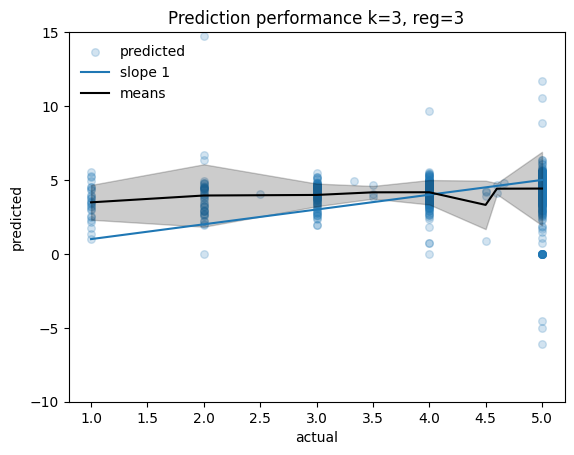

In [46]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=3" )

MSE: 5.137443955567251


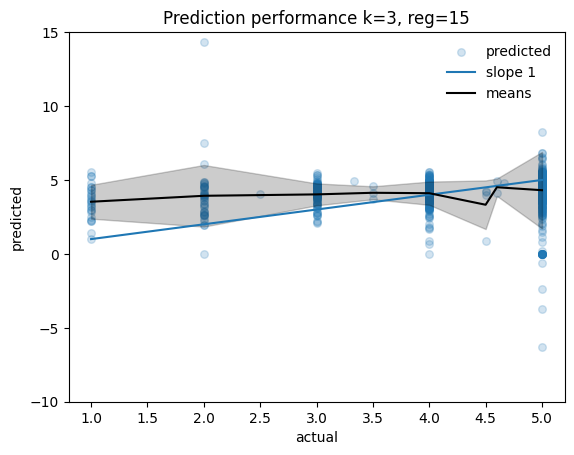

In [47]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=15.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=15" )

MSE: 113.08492380223288


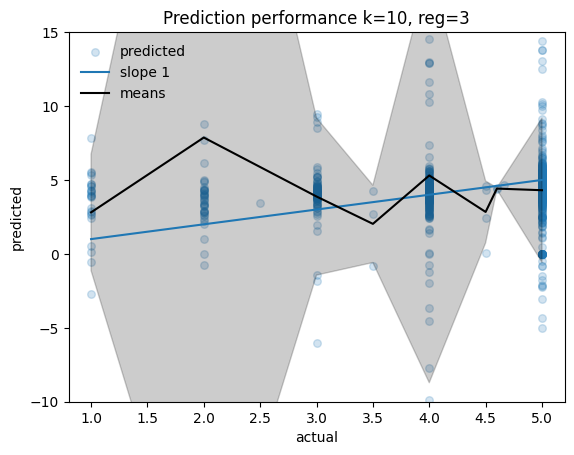

In [48]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=10, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=10, reg=3" )

Los cuatro gráficos anteriores muestran cuán precisas son nuestras predicciones. Si las predicciones son 100% precisas, todos los puntos deben estar en la línea de pendiente 1. En nuestro caso esto no es posible debido a la sencillez del modelo. De esta forma obtenemos una banda de puntos que corresponden a cada calificación real. Cuanto más estrecha sea la banda, mayor será la precisión de la predicción. La línea azul que forma la media de predicción puede ofrecernos un sesgo estimado de la predicción. La banda gris también se utiliza para mostrar precisión.

Las diferencias en los tres gráficos nos dicen que usar un número menor de vecinos más cercanos puede ayudar a mejorar la precisión de la predicción. Esto es intuitivamente correcto porque los elementos que son similares deberían ser mucho más informativos que los elementos menos similares para la predicción. El parámetro de regularización no tiene un efecto claro sobre la predicción. Comparando las tres configuraciones, preferiríamos el modelo con 3 vecinos más cercanos y el parámetro de regularización 3.

También hay una observación bastante interesante. El sesgo de la predicción parece ser muy pequeño cuando la puntuación real es de alrededor de 4 y relativamente mayor cuando la puntuación se acerca a 1 y 5. Esto tiene sentido intuitivo ya que los puntos reales extremos pueden ser valores atípicos y hacer que el modelo funcione peor, mientras que cuando La puntuación está en un rango moderado, podría ser más sólida para el modelo que estamos utilizando.

### Limitar las estimaciones de calificaciones para una variación menor

Como podemos ver, las variaciones de las estimaciones del enfoque de similitud son bastante grandes. La razón principal es que muchas estimaciones son mayores que 5 o menores que 0, lo que está fuera del rango de calificaciones reales. Podemos reducir la varianza limitando las estimaciones para que estén entre 0 y 5. Lo implementamos en `rating_cap`:

In [49]:
def rating_cap( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # seperate three fields from the output of knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calculate baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #handle cases where the denominator is zero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #get rid of nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    if rating_adj<0:
        rating_adj = 0
    if rating_adj>5:
        rating_adj = 5
    
    return rating_adj

Repetimos los mismos análisis en el Ejercicio 8 y los resultados se enumeran a continuación:

MSE: 1.500673653026886


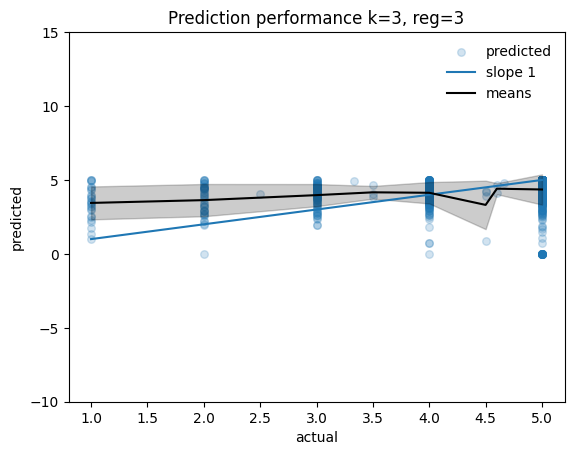

In [50]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=3" )

MSE: 1.572254365234287


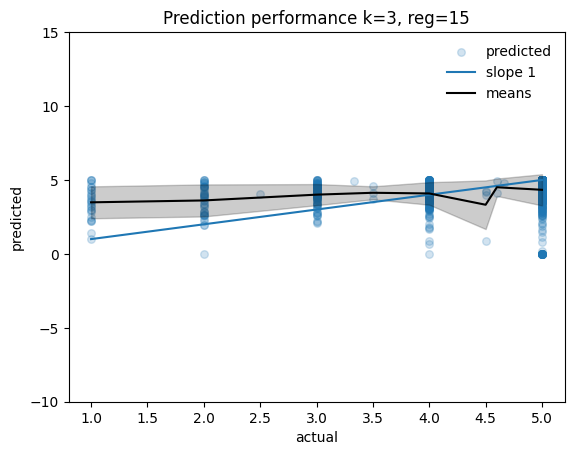

In [51]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=15.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=15" )

MSE: 2.199468758727016


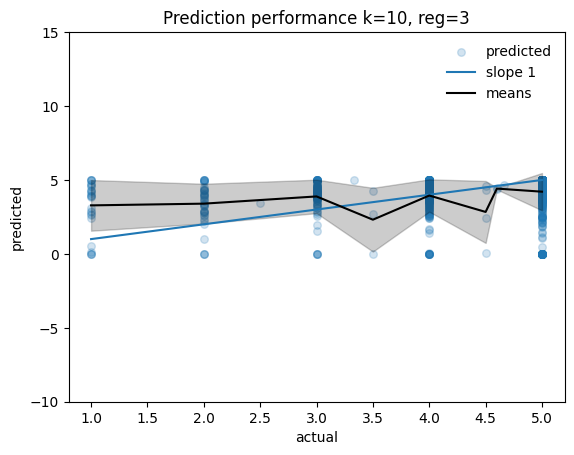

In [52]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=10, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=10, reg=3" )

Está claro que después de la limitación, el MSE general se reduce significativamente. Sin embargo, también encontramos, con base en las cifras, que las calificaciones estimadas tienden a tener un mayor sesgo, como lo refleja la desviación de las curvas negras hacia la curva azul en cada figura. Esto ilustra el típico equilibrio entre sesgo y varianza.

## Latent factor recommendations: nonnegative matrix factorization

Procedamos ahora a utilizar un enfoque basado en factores latentes para construir un sistema de recomendación. La forma de extraer estos factores latentes es **factorización matricial no negativa (NMF)**.

### The latent factor model 

#### Descripción general del modelo

La idea central al construir un sistema de recomendación utilizando filtrado colaborativo es que *usuarios similares calificarán películas similares de manera similar*. En las secciones anteriores, implementamos explícitamente esta idea mediante el uso de medidas de similitud. También asumimos que todos los usuarios eran iguales (el enfoque global) o que solo el usuario actual era lo suficientemente similar como para hacer una recomendación (el enfoque específico del usuario). En esta sección, utilizaremos un modelo que nos permite identificar tanto usuarios similares como películas similares en función de **factores latentes**.

Podemos pensar en los factores latentes como propiedades de las películas (por ejemplo, género, precio, duración) por las que los usuarios tienen una preferencia positiva o negativa. No observamos estos factores ni las preferencias de los usuarios directamente, pero asumimos que afectan la forma en que los usuarios tienden a calificar las películas. Por ejemplo, una película extremadamente larga recibiría una calificación baja si el crítico prefiere títulos de ritmo rápido. Tenga en cuenta que si los usuarios tienen preferencias similares, según el modelo, se comportarán de manera similar y, de la misma manera, si las películas tienen factores latentes similares, serán calificadas de manera similar por usuarios similares.

Una cuestión que surge con los modelos de factores latentes es determinar cuántos factores latentes incluir. Podemos abordar el problema de elegir el número de factores latentes con validación cruzada.

#### Especificación del modelo de calificación

Denotemos la calificación real de la película $m$ del usuario $u$ como $Y_{um}$. En nuestro conjunto de datos, tenemos $N$ usuarios distintos y $M$ películas distintas. No todas las combinaciones de películas y usuarios tienen calificaciones. Suponemos que hay $L$ reseñas en total. El modelo de factor latente que especificamos supone que cada película está asociada con un factor latente $K$-dimensional $v_m$ y cada usuario está asociado con un factor latente $K$-dimensional $w_u$. Además, suponemos que:

$$
Y_{um} = v_m^\intercal w_u
$$

Tenga en cuenta que según la especificación de este modelo, si dos películas tienen $v_m$ muy similares, la puntuación asociada $Y$ de cualquier usuario debería ser similar. Y si dos usuarios tienen $w_u$ muy similares, sus calificaciones para cualquier película también deberían ser muy similares. La siguiente figura proporciona un resumen muy claro de las especificaciones del modelo:
![](factor_model.png)
*Image from this [website](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)*

#### Estimación para este modelo

Usando este modelo, queremos estimar $v$ y $w$ para todos los usuarios y todas las películas, antes de lo cual también es importante determinar $K$. Existen numerosas formas de estimar estas cantidades, pero en esta sección nos centraremos en la factorización matricial no negativa (NMF). La idea de este enfoque es que tanto $w$ como $v$ tienen que ser vectores no negativos. Esta restricción hace que la predicción de cualquier revisión no observada no sea negativa y desalienta las calificaciones extremadamente altas previstas, lo cual es la principal ventaja del enfoque NMF en comparación con el enfoque que introdujimos anteriormente.

No importa cuál sea la implementación de la factorización matricial que estemos utilizando, el objetivo final de la estimación es aproximarse lo más posible a las calificaciones observadas. Esto generalmente se logra minimizando el error cuadrático medio de las calificaciones previstas para las revisiones que están disponibles en el conjunto de datos de entrenamiento.

Proporcionamos la función `recommend_nmf` basada en el paquete `surprise` para predecir las calificaciones de un usuario específico para una película específica. La entrada es un DataFrame de revisiones y la cantidad de factores latentes. La salida es un objeto `algo` ajustado:


In [76]:
!python3 -m pip install -q surprise

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [77]:
def recommend_nmf(df, K):
    from surprise import NMF
    from surprise import Reader, Dataset
    
    reader = Reader()
    data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo = NMF(n_factors=K)
    algo.fit(trainset)
    return algo

Usar `recommend_nmf` para estimar las calificaciones de las revisiones en `test` basándose en `train` en el Ejercicio 8. Visualice los resultados como en el Ejercicio 8 para `K=5`, `K=20`, `K=50`. Según los resultados, ¿prefiere el método NMF o el método del vecino más cercano?

MSE: 1.5734214309591958


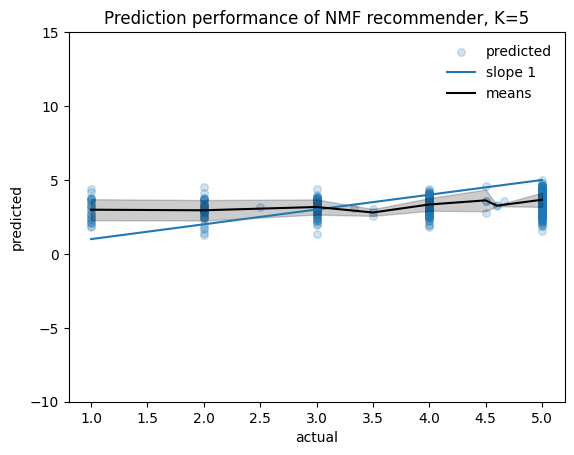

In [62]:
# K=5
rec_K5 = recommend_nmf(train, K=5)
pred_K5 = [rec_K5.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K5, title = "Prediction performance of NMF recommender, K=5" )

In [81]:
test

,user,item,rating,user_mean,movie_mean
7729,A3JCKCPZHK4CZP,6302091632,5.0,5.000000,4.402985
11335,AW3VZ5O895LRK,B0049P1ZZQ,5.0,4.736842,4.553846
6926,A39AWL2FKWDFK6,B00005JLWN,5.0,4.666667,3.775281
1914,A1JH5J1KQAUBMP,0788802194,4.0,4.191489,4.705882
10038,AHIK7BUXFRMT8,B00005JLF2,4.0,4.571429,4.507937
...,...,...,...,...,...
10846,AQUVTQFFXP4AC,B000VS20M2,5.0,3.500000,4.429741
5753,A2TXR85WQLE32N,B00005JNJV,5.0,4.571429,4.480545
1857,A1IUI3CJUMB7J0,B0009XRZ9M,3.0,3.727273,4.109890
981,A1AISPOIIHTHXX,B0000DKMK0,4.0,4.512195,4.152705


In [ ]:
# K=20
rec_K20 = recommend_nmf(train, K=20)
pred_K20 = [rec_K20.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K20, title = "Prediction performance of NMF recommender, K=20" )

MSE: 0.9654296307171395


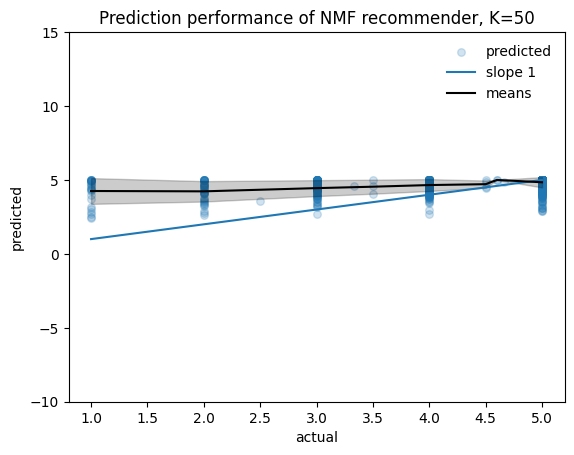

In [66]:
# K=50
rec_K50 = recommend_nmf(train, K=50)
pred_K50 = [rec_K50.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K50, title = "Prediction performance of NMF recommender, K=50" )

De los resultados encontramos que el MSE más pequeño lo logra NMF con $K=20$. También encontramos que la varianza de los valores predichos por NMF es mucho menor que la del método del vecino más cercano; esto se debe principalmente a la restricción de no negatividad. Incluso si realizamos una reducción de la varianza en el método del vecino más cercano mediante limitación, el MSE más pequeño en el conjunto de prueba que observamos sigue siendo mayor que el del modelo NMF de mejor rendimiento. Además, el costo computacional de NMF es mucho menor que el del enfoque del vecino más cercano, ya que en NMF no se requiere una matriz de similitud por pares. Con base en estas observaciones, preferimos el enfoque NMF sobre el enfoque del vecino más cercano.

Sin embargo, NMF aún no puede resolver problemas de nuevos usuarios/elementos y, en general, el sesgo de los valores predichos es mayor que en el enfoque del vecino más cercano debido a una compensación entre sesgo y varianza.

### Efecto de $K$ en la prediccion

Para visualizar mejor el efecto de $K$ en la precisión de la predicción de las calificaciones, trazamos el MSE como una función de $K$:

In [67]:
from sklearn.metrics import mean_squared_error
mse_all = []

for K in range(2,51):
    rec_K = recommend_nmf(train, K=K)
    pred_K = [rec_K.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
    mse_all.append(mean_squared_error(test.rating, pred_K))

Text(0.5, 1.0, 'Prediction accuracy of NMF model when K changes')

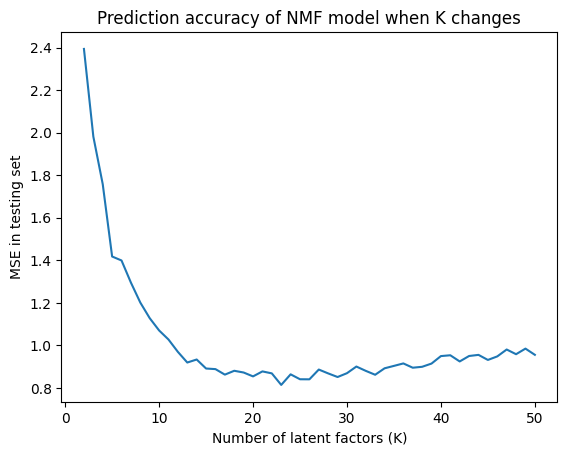

In [68]:
plt.plot(range(2,51), mse_all);
plt.xlabel("Number of latent factors (K)");
plt.ylabel("MSE in testing set");
plt.title("Prediction accuracy of NMF model when K changes")

Cuando $K$ aumenta, el modelo se ajusta a los datos con mayor precisión. Sin embargo, esto no implica directamente que la precisión de la predicción del modelo entrenado también aumentará cuando se evalúe en un conjunto de pruebas externo. La curva que mostramos arriba muestra que si $K$ es demasiado grande ($>20$), el MSE del conjunto de prueba en realidad aumenta, lo que indica un sobreajuste del modelo a los datos de entrenamiento. Este gráfico puede servir como una forma de seleccionar $K$ en la práctica.

## Conclusión

En este estudio de caso, construimos sistemas de recomendación para películas basados ​​únicamente en datos de reseñas. Nuestro primer recomendador examinó la correlación entre reseñas de críticos comunes y utilizó la correlación para asignar similitudes entre películas. También introdujimos un sistema de recomendación alternativo construido descomponiendo directamente la matriz elemento-usuario en factores latentes de baja dimensión y utilizamos los factores latentes identificados para estimar la calificación de un usuario para una película aún no vista. Al ordenar la calificación estimada, se puede generar una lista de elementos recomendados.

Encontramos que el primer enfoque tiende a tener un sesgo menor pero una varianza mayor, mientras que el segundo enfoque produce predicciones de varianza baja con un sesgo elevado. También observamos que el segundo enfoque es computacionalmente más eficiente. Teniendo en cuenta el hecho de que los datos de que disponemos seguirán aumentando, el segundo enfoque es probablemente la mejor opción.

## Comidas para llevar (5 min)

En este caso, presentamos dos enfoques para la recomendación de películas: el enfoque del vecino más cercano y el enfoque de factorización matricial. Se proponen ambos enfoques para abordar la gran escasez en el conjunto de datos de revisión y cada uno con sus pros y sus contras. Encontramos que, en general, el enfoque de factorización matricial es computacionalmente más eficiente con menor incertidumbre para las calificaciones previstas. Por otro lado, el enfoque del vecino más cercano requiere un uso computacional intensivo debido al cálculo de la similitud por pares. Es más inestable en la predicción de calificaciones en comparación con el enfoque MF, pero tiene un sesgo menor. Desafortunadamente, ninguno de estos dos enfoques puede abordar la cuestión de los artículos nuevos. En nuestro próximo caso, deberíamos abordar este problema utilizando información externa sobre usuarios y películas.